In [19]:
import numpy as np
import pints
import pints.plot
import pints_smol_moments_4_normalised_jit as toy
import matplotlib.pyplot as plt
from scipy.stats import moment
import pandas as pd



Select the desired model, true parameters and time array.

Then simulate to get synthetic data

In [20]:

model = toy.SmolModel(None,None)


true_parameters = [0.0003, 900]


times = np.linspace(20, 90, 71)

df = pd.read_csv('2017-03-16_inference_input_multi_well_t_20.csv', header=None)
org_values = np.transpose(df.to_numpy())
org_values = org_values[:71,:]


# 1st moment is mean, 1st centred moment should be array 6
centred_moment_1 = moment(org_values, moment=1, axis=1)
centred_moment_2 = moment(org_values, moment=2, axis=1)
centred_moment_3 = moment(org_values, moment=3, axis=1)
centred_moment_4 = moment(org_values, moment=4, axis=1)

# Out array, mean, variance then centred standardised moments (aka skewness, kurtosis, hyperskewness)
st_dev = np.sqrt(centred_moment_2)
out_array = np.zeros((71,4))
out_array[:,0] = np.mean(org_values,axis=1)
out_array[:,1] = centred_moment_2
out_array[:,2] = np.divide(centred_moment_3,st_dev*st_dev*st_dev)
out_array[:,3] = np.divide(centred_moment_4,st_dev*st_dev*st_dev*st_dev)

# print(st_dev)

# print(np.mean(org_values, axis=1))
# print(centred_moment_3)



Add noise to the data (using random sampling from normal distribution)

In [21]:

# noise = 9
# values = org_values + np.random.normal(0, noise, org_values.shape)

size_noise = 4
noise_value = 1
# # Create a list with the specified size filled with a placeholder value
noise_arr = [noise_value for _ in range(size_noise)]
# noise_arr[0] = 1
# noise_arr[1] = 1
# noise_arr[2] = 1
# noise_arr[3] = 1


Set-up pints problem and log likelihoods

In [22]:

# problem = pints.MultiOutputProblem(model, times, centred_moments)
problem = pints.MultiOutputProblem(model, times, out_array)

log_likelihood = pints.GaussianLogLikelihood(problem)
# log_likelihood_2 = pints.GaussianIntegratedLogUniformLogLikelihood(problem)

print('Original problem dimension: ' + str(problem.n_parameters()))
print('New dimension: ' + str(log_likelihood.n_parameters()))
# print('New dimension: ' + str(log_likelihood_2.n_parameters()))

true_parameters += noise_arr
# print(true_parameters)



Original problem dimension: 2
New dimension: 6


Create uniform log prior

In [23]:

# Define the size of the list
size = 6
placeholder_lower_value = 0
placeholder_upper_value = 1000
 
# Create a list with the specified size filled with a placeholder value
prior_arr_lower = [placeholder_lower_value for _ in range(size)]
prior_arr_upper = [placeholder_upper_value for _ in range(size)]
prior_arr_lower[0] = 0.00001
prior_arr_upper[0] = 0.001
prior_arr_lower[1] = 1
prior_arr_upper[1] = 4000
prior_arr_lower[2] = 0
prior_arr_upper[2] = 100
prior_arr_lower[3] = 0
prior_arr_upper[3] = 100
prior_arr_lower[4] = 0
prior_arr_upper[4] = 100
prior_arr_lower[5] = 0
prior_arr_upper[5] = 100


# log_prior = pints.UniformLogPrior(
#     [0.000001, 1, 1],
#     [0.01, 10000, 100]
#     )
log_prior = pints.UniformLogPrior(
    prior_arr_lower,
    prior_arr_upper
    )

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)


/var/folders/lt/9g_w308946v4x_5mqxc951qr0000gr/T/ipykernel_84875/152966210.py:27: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  log_prior = pints.UniformLogPrior(


In [24]:

xs = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.15,
]
ITERS = 10000
mcmc = pints.MCMCController(log_posterior, 3, xs, method=pints.SliceDoublingMCMC)
mcmc.set_max_iterations(ITERS)
chains = mcmc.run()
print(chains)



Using Slice Sampling - Doubling
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Time m:s
0     3       0:00.0


1     444     0:01.1
2     879     0:02.1
3     1284    0:03.2
20    7470    0:18.0
40    12600   0:31.2
60    17436   0:43.9
80    22407   0:56.3
100   27486   1:09.3
120   32595   1:22.3
140   37788   1:35.9
160   42726   1:48.5
180   47721   2:01.3
200   52674   2:14.3
220   57690   2:27.2
240   62700   2:39.8
260   67629   2:52.5
280   72423   3:05.0
300   77250   3:17.4
320   81930   3:29.0
340   86637   3:41.4
360   91647   3:54.0
380   96513   4:06.2
400   101604   4:19.7
420   106551   4:32.4
440   111594   4:45.4
460   116316   4:58.0
480   121410   5:11.4
500   126489   5:24.6
520   131712   5:38.0
540   136344   5:50.2
560   141174   6:02.8
580   146367   6:15.7
600   151140   6:27.4
620   156012   6:39.6
640   160995   6:52.6
660   166032   7:05.0
680   171222   7:18.0
700   176232   7:30.7
720   181293   7:44.0
740   186249   7:56.3
760   191283   8:08.9
780   196305   8:21.5
800   201279   8:34.4
820   206244   8:47.2
840   211548   9:00.7
860   216624   9:13.2
880   2215

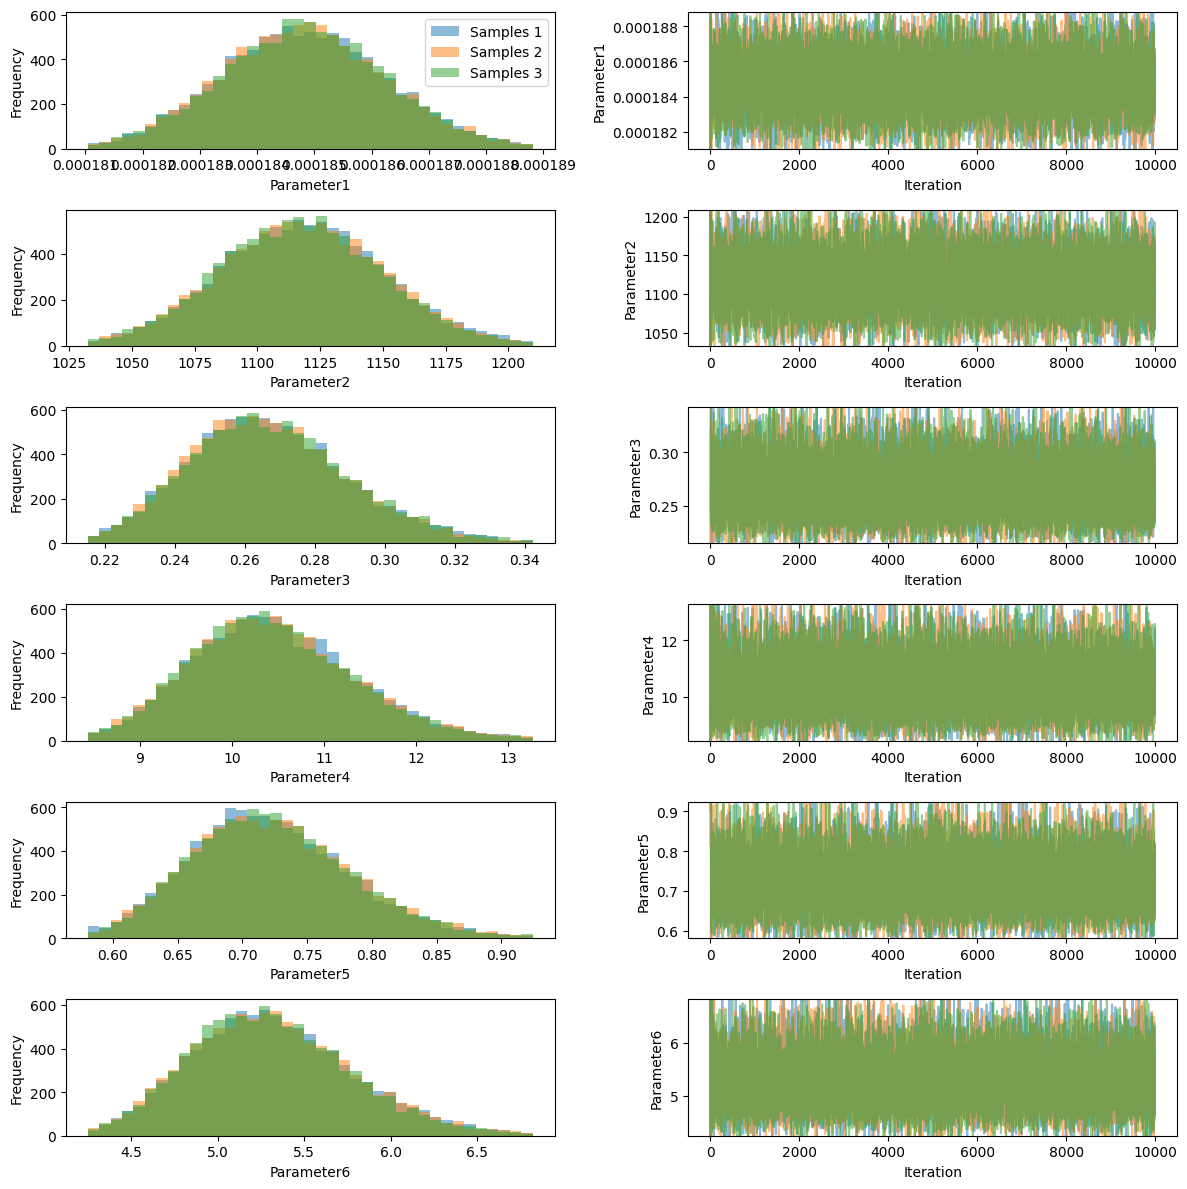

In [25]:

pints.plot.trace(chains, n_percentiles=99)
plt.savefig("mcmc.png")
plt.show()


In [26]:

# ITERS = 100
AllChains = chains[0,100:10000,:]
# np.asarray(AllChains)
print(np.shape(AllChains))
print(AllChains[0])
print(AllChains)


(9900, 6)
[1.85909061e-04 1.13579749e+03 2.68526717e-01 1.11428760e+01
 6.36353970e-01 4.63185393e+00]
[[1.85909061e-04 1.13579749e+03 2.68526717e-01 1.11428760e+01
  6.36353970e-01 4.63185393e+00]
 [1.83289756e-04 1.16343325e+03 2.66434479e-01 1.05042904e+01
  6.68966752e-01 6.36059904e+00]
 [1.83427591e-04 1.13661307e+03 2.49759082e-01 1.11458782e+01
  7.43532509e-01 6.26182476e+00]
 ...
 [1.83952825e-04 1.14737232e+03 2.90378053e-01 1.02838172e+01
  7.43630933e-01 5.59855850e+00]
 [1.83765226e-04 1.11377914e+03 2.67536582e-01 9.35397849e+00
  7.27862907e-01 5.60112239e+00]
 [1.85921274e-04 1.09548772e+03 2.48781974e-01 1.16487647e+01
  7.44239813e-01 5.34749484e+00]]


In [27]:

for I in range(3-1):
    AllChains_add = chains[I+1,100:10000,:]
    AllChains = np.concatenate((AllChains,AllChains_add), axis=0)


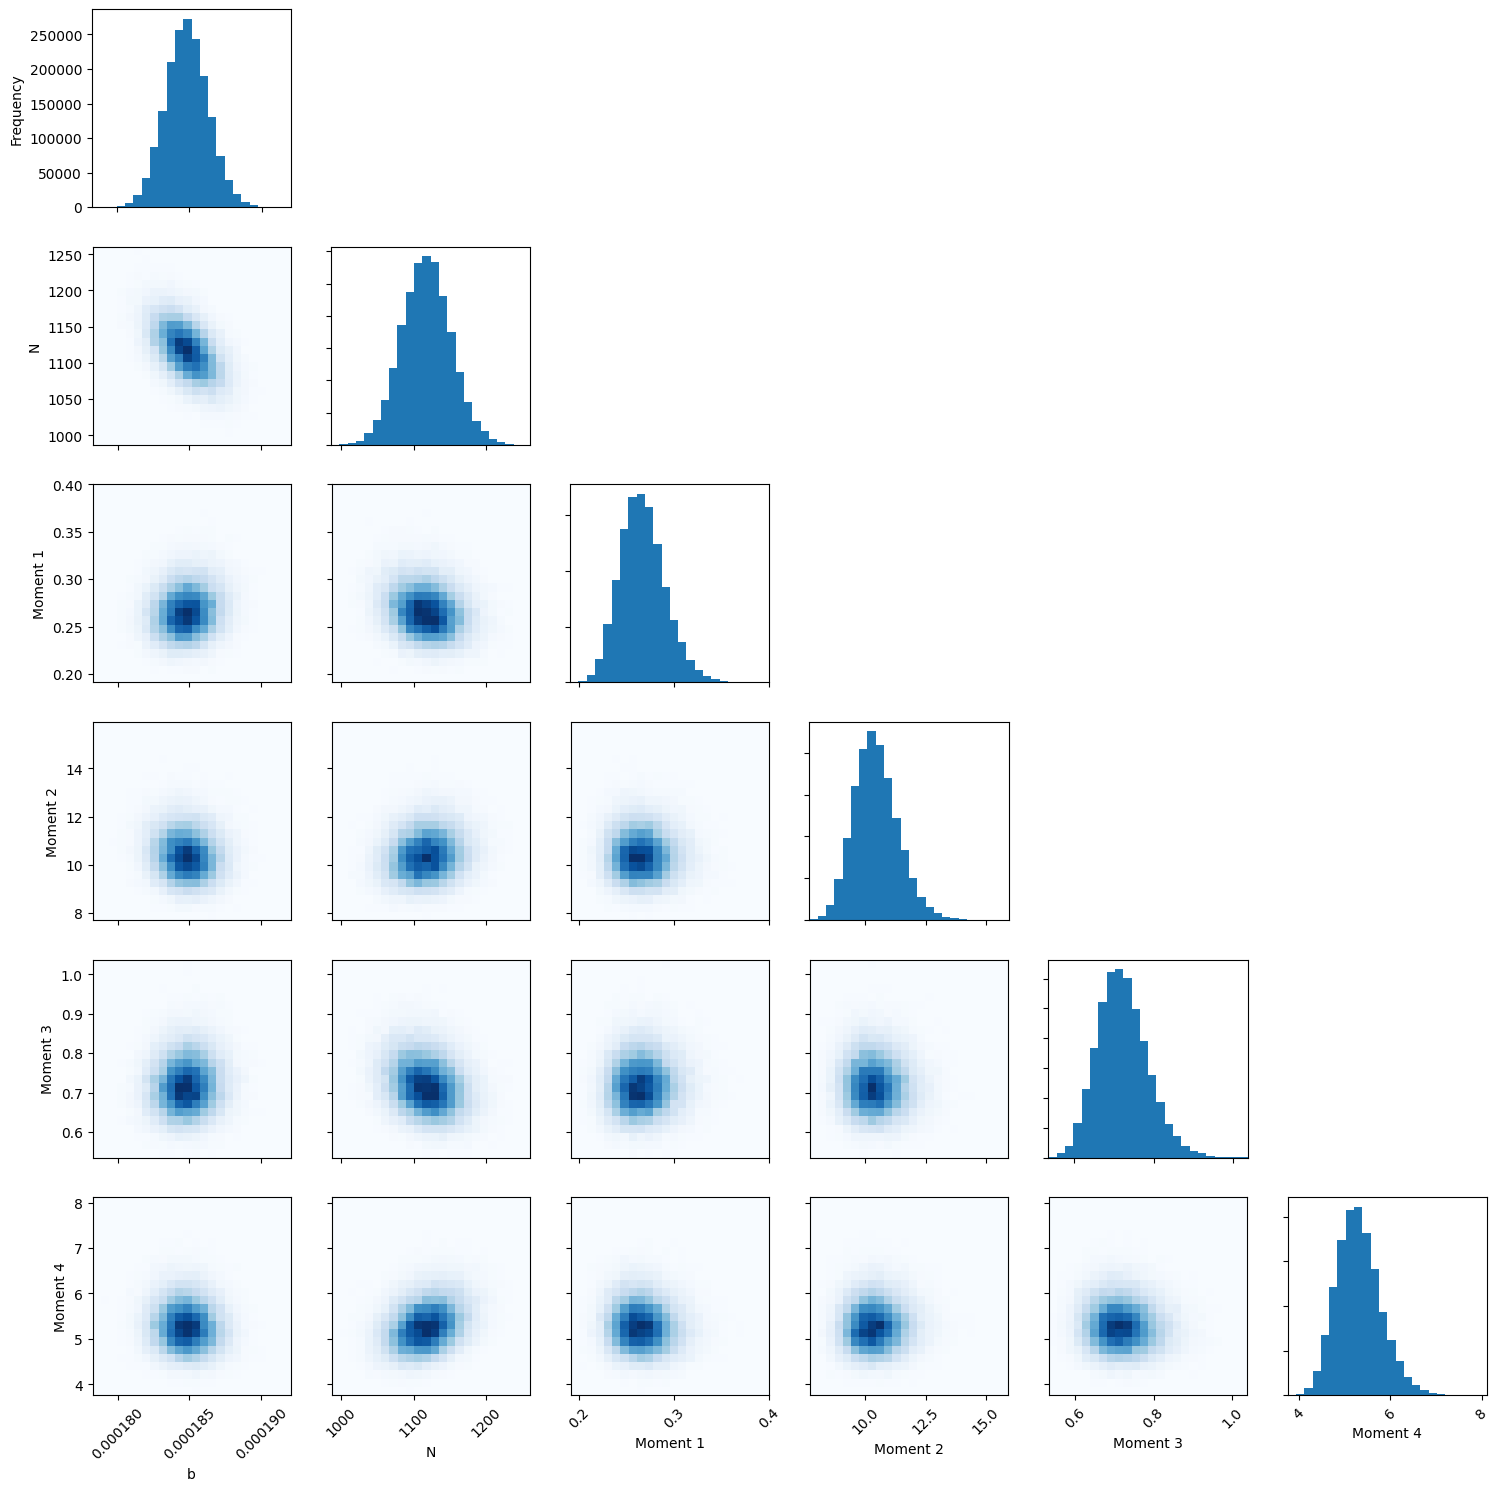

In [28]:


parameter_names = ["b","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4"]
#pints.plot.pairwise(chains, kde=True, parameter_names=parameter_names)

pints.plot.pairwise(AllChains, heatmap=True, 
                    parameter_names=["b","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4"])
plt.show()

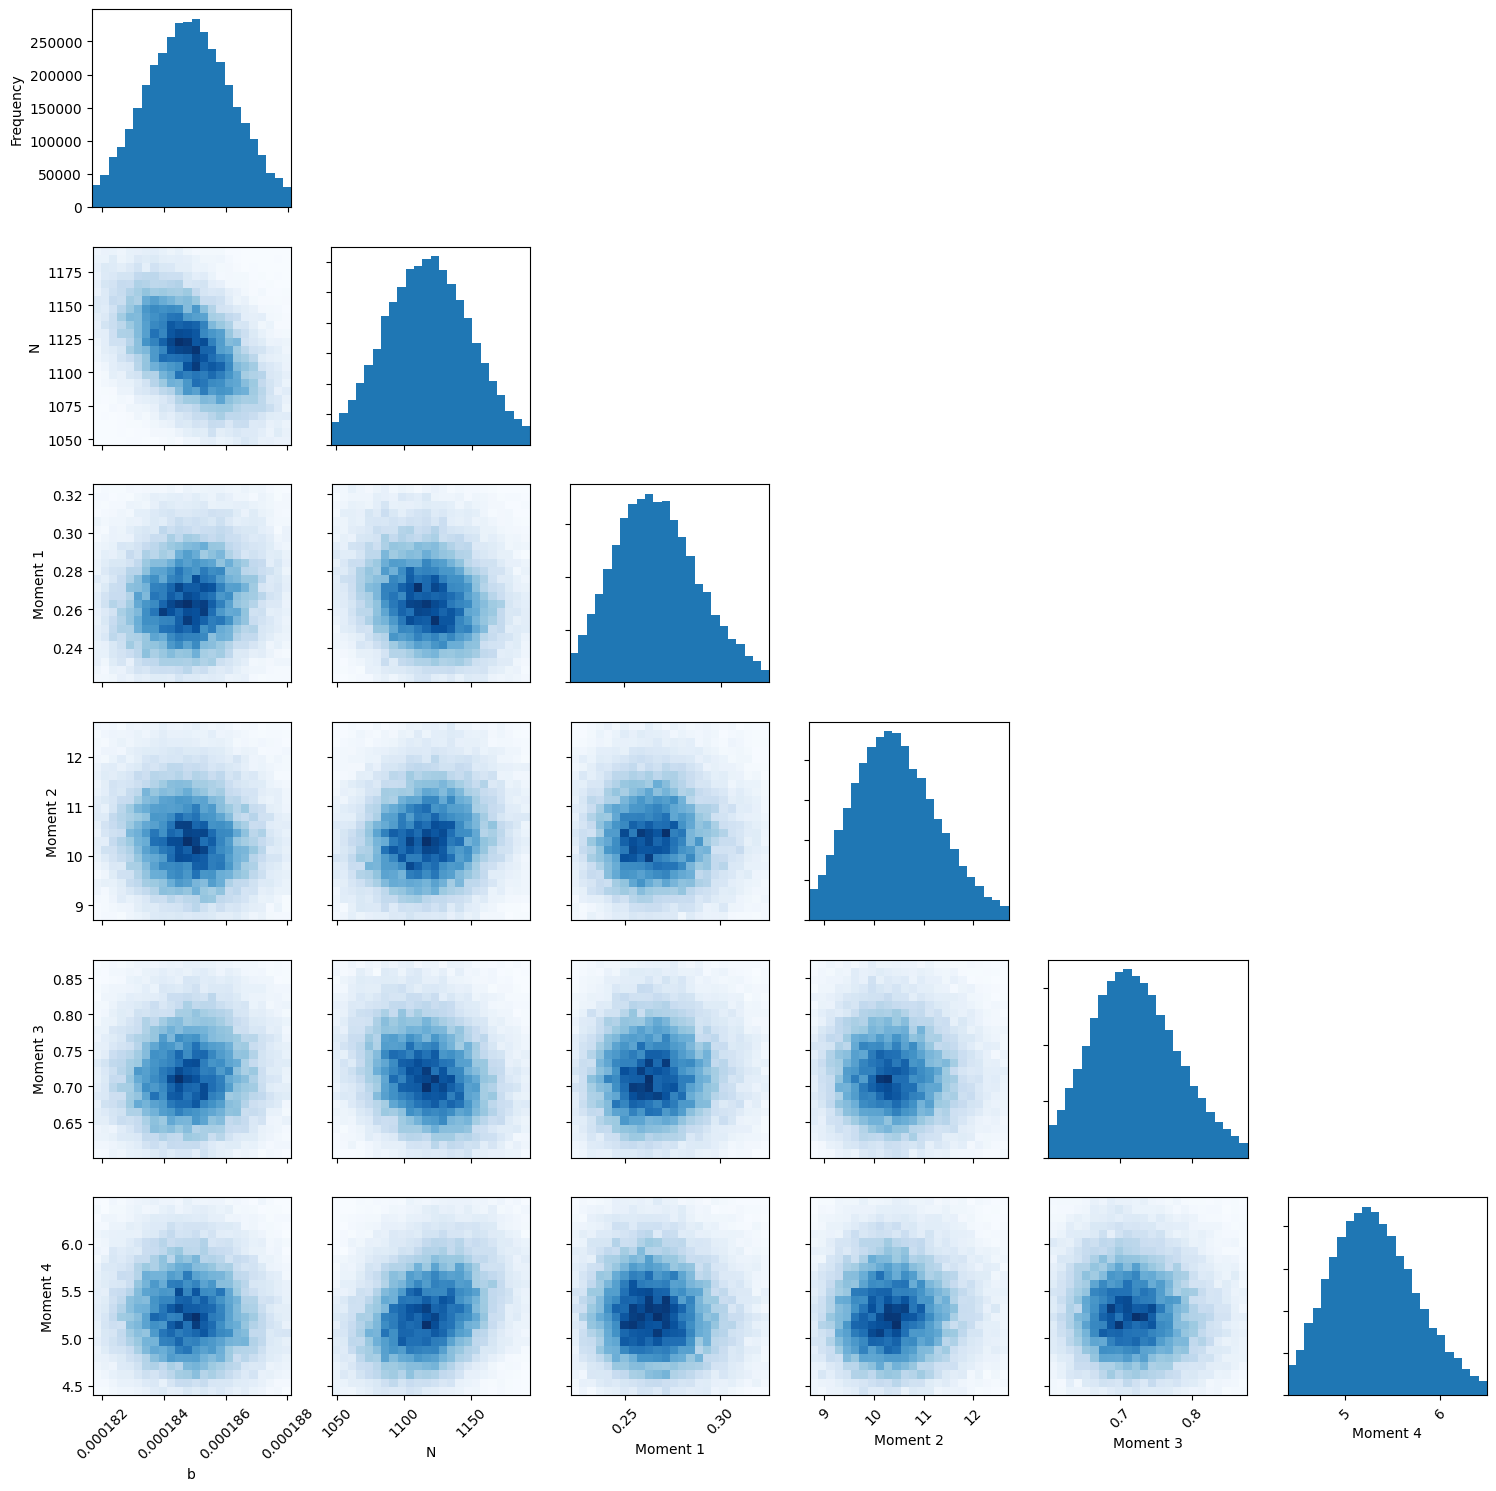

In [29]:
parameter_names = ["b","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4"]
#pints.plot.pairwise(chains, kde=True, parameter_names=parameter_names)

pints.plot.pairwise(AllChains, heatmap=True, 
                    parameter_names=["b","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4"],
                    n_percentiles=97)
                    
plt.show()

[1.85909061e-04 1.13579749e+03 2.68526717e-01 1.11428760e+01
 6.36353970e-01 4.63185393e+00]


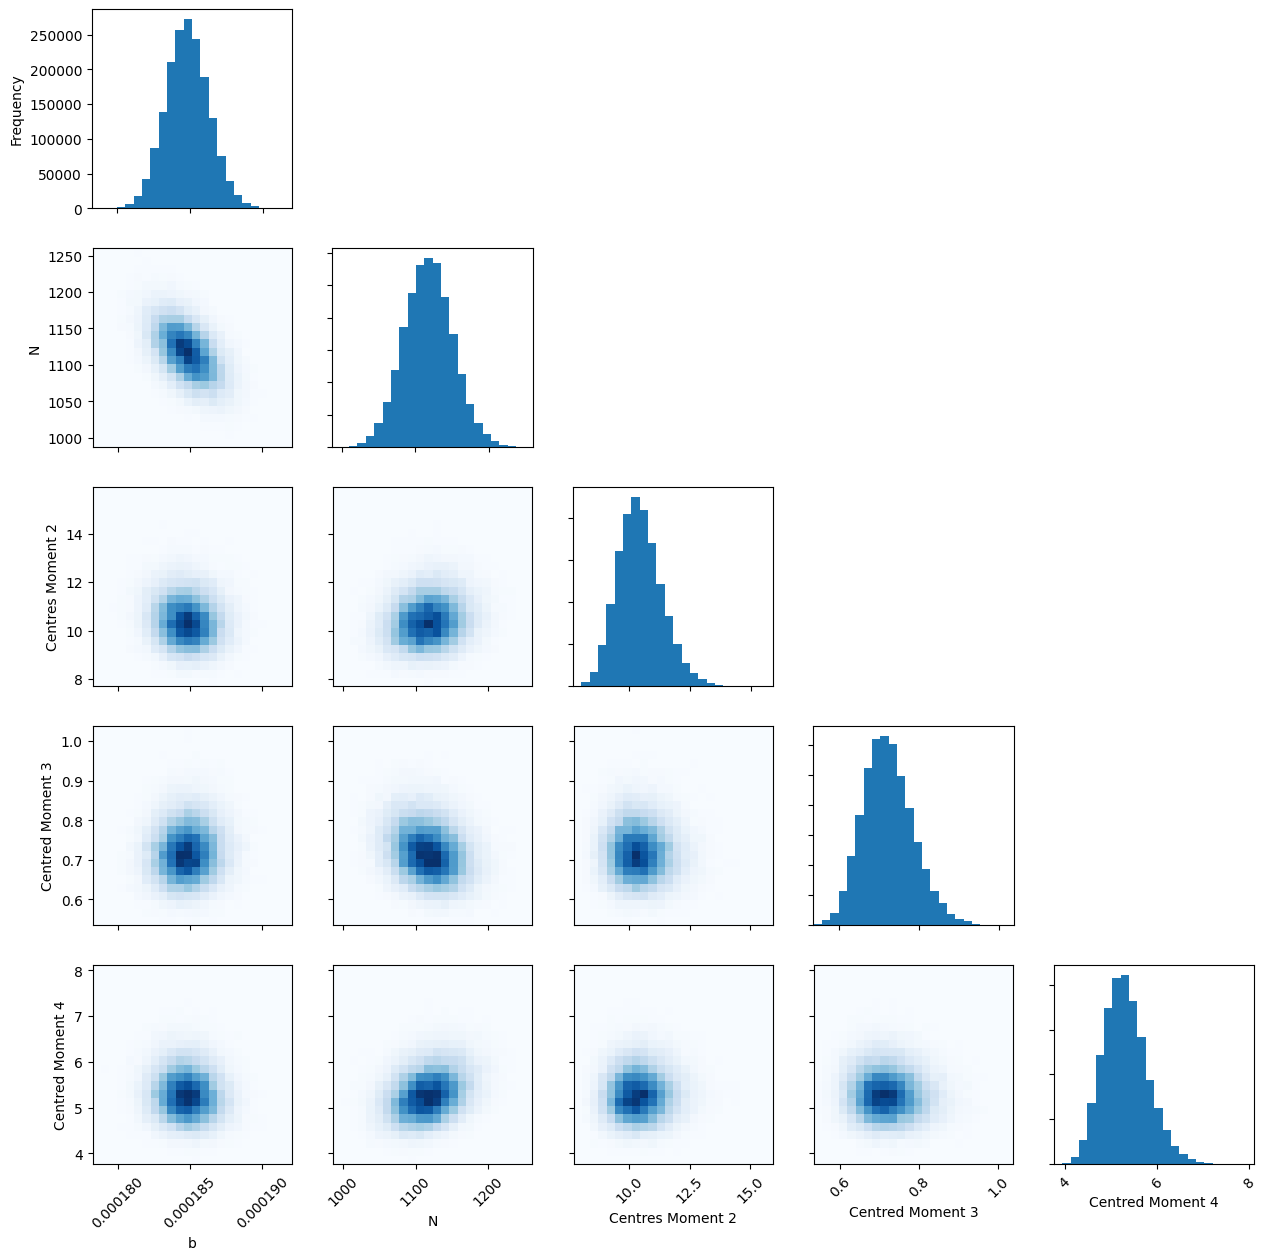

In [30]:
parameter_names = ["b","N", "Moment 2", "Moment 3", "Moment 4"]
#pints.plot.pairwise(chains, kde=True, parameter_names=parameter_names)
print(AllChains[0])
pints.plot.pairwise(AllChains[:,[0,1,3,4,5]], heatmap=True, 
                    parameter_names=["b","N", "Centres Moment 2", "Centred Moment 3", "Centred Moment 4"])
plt.savefig("Pints_pairwise.png", dpi =300)
plt.show()


In [31]:
parameter_names = ["b","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4"]
results = pints.MCMCSummary(chains=chains[:,int(ITERS/2):, :], time=mcmc.time(),
                            parameter_names = parameter_names)
print(type(results))
print(results)


<class 'pints._mcmc._summary.MCMCSummary'>
param     mean     std.    2.5%     25%      50%      75%      97.5%    rhat    ess      ess per sec.
--------  -------  ------  -------  -------  -------  -------  -------  ------  -------  --------------
b         0.00     0.00    0.00     0.00     0.00     0.00     0.00     1.00    3839.29  0.61
N         1117.30  33.46   1051.80  1094.23  1117.32  1139.73  1183.27  1.00    3597.80  0.58
Moment 1  0.27     0.02    0.23     0.25     0.27     0.28     0.32     1.00    4698.43  0.75
Moment 2  10.45    0.90    8.86     9.82     10.39    11.01    12.38    1.00    4592.40  0.74
Moment 3  0.72     0.06    0.61     0.68     0.72     0.76     0.86     1.00    4598.75  0.74
Moment 4  5.31     0.48    4.47     4.97     5.28     5.61     6.34     1.00    4410.03  0.71


In [32]:
from tabulate import tabulate
class MyMCMCSummary(pints.MCMCSummary):
    def __str__(self):
        """
        Prints posterior summaries for all parameters to the console, including
        the parameter name, posterior mean, posterior std deviation, the
        2.5%, 25%, 50%, 75% and 97.5% posterior quantiles, rhat, effective
        sample size (ess) and ess per second of run time.
        """
        if self._summary_str is None:
            headers = [
                'param', 'mean', 'std.',
                '2.5%', '25%', '50%', '75%', '97.5%',
                'rhat', 'ess']
            if self._time is not None:
                headers.append('ess per sec.')

            self._summary_str = tabulate(
                self._summary_list,
                headers=headers,
                numalign='left',
                floatfmt='.3g',
            )

        return self._summary_str
    


In [33]:

parameter_names = ["b","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4"]
results = MyMCMCSummary(chains=chains[:,int(ITERS/2):, :], time=mcmc.time(),
                            parameter_names = parameter_names)
print(type(results))
print(results)

<class '__main__.MyMCMCSummary'>
param     mean      std.      2.5%      25%       50%       75%       97.5%     rhat    ess       ess per sec.
--------  --------  --------  --------  --------  --------  --------  --------  ------  --------  --------------
b         0.000185  1.47e-06  0.000182  0.000184  0.000185  0.000186  0.000188  1       3.84e+03  0.615
N         1.12e+03  33.5      1.05e+03  1.09e+03  1.12e+03  1.14e+03  1.18e+03  1       3.6e+03   0.576
Moment 1  0.267     0.0234    0.226     0.251     0.266     0.282     0.317     1       4.7e+03   0.752
Moment 2  10.4      0.895     8.86      9.82      10.4      11        12.4      1       4.59e+03  0.735
Moment 3  0.723     0.0629    0.612     0.679     0.719     0.762     0.857     1       4.6e+03   0.736
Moment 4  5.31      0.476     4.47      4.97      5.28      5.61      6.34      1       4.41e+03  0.706


In [57]:
import math
print(math.log(4))
results.mean()

print(len(results.mean()))

AIC = 2*len(results.mean()) - 2*log_likelihood(results.mean())

print(AIC)


BIC = len(results.mean())*math.log(4) - 2*log_likelihood(results.mean())

print(BIC)

1.3862943611198906
6
1142.7677746561724
1139.0855408228917


In [63]:
shape_chains = np.shape(AllChains)

DIC_1 = 0
for i in range(shape_chains[0]):
    thetas = AllChains[i,:]
    DIC_1 += -2*log_likelihood(thetas)

DIC_1 = DIC_1/shape_chains[0]

DIC_2 = -2*log_likelihood(results.mean())

DIC = 2*DIC_1 - DIC_2

print(DIC)


1142.6093785604178


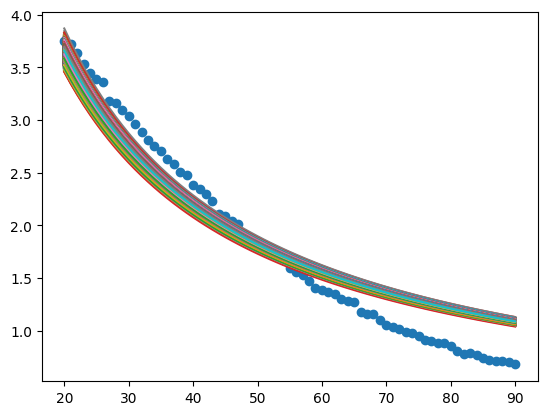

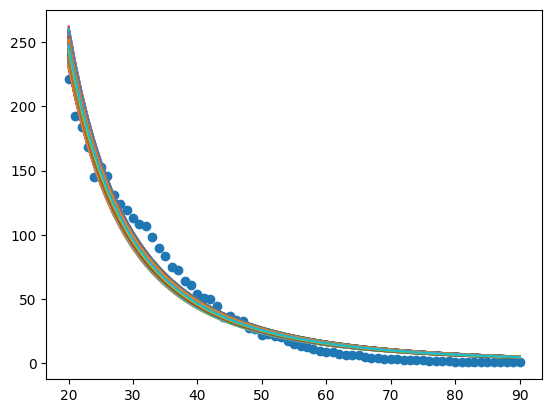

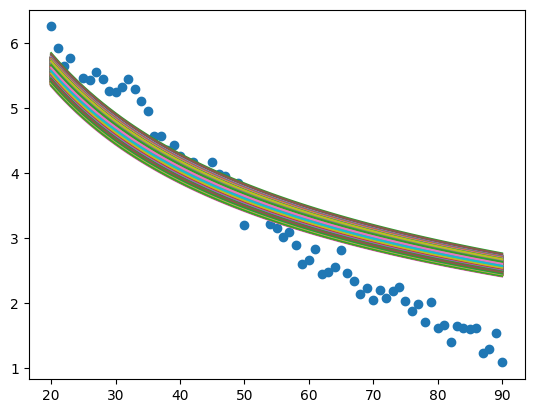

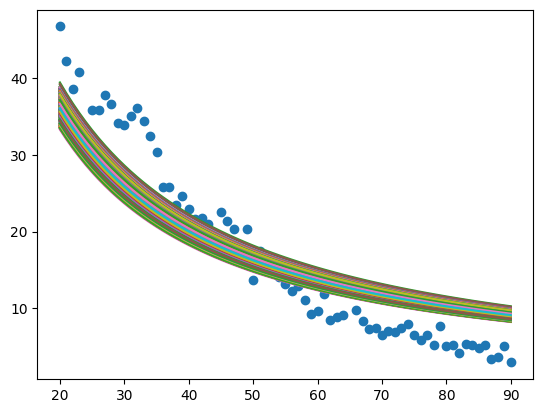

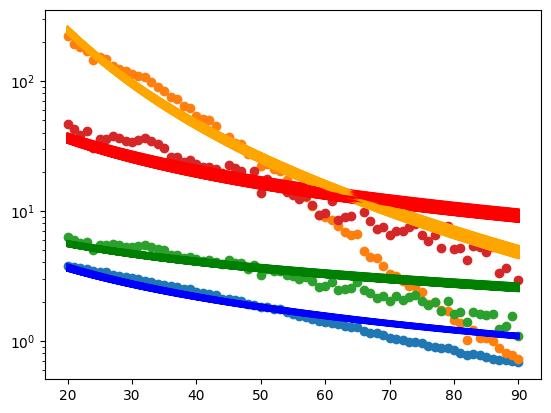

In [71]:
shape_chains = np.shape(AllChains)



data_mean = out_array[:,0]
data_variance = out_array[:,1]
data_skewness = out_array[:,2]
data_kurtosis = out_array[:,3]

plt.figure(1)
plt.scatter(times, data_mean)
plt.figure(2)
plt.scatter(times, data_variance)
plt.figure(3)
plt.scatter(times, data_skewness)
plt.figure(4)
plt.scatter(times, data_kurtosis)

plt.figure(5)
plt.yscale("log")
plt.scatter(times, data_mean)
plt.scatter(times, data_variance)
plt.scatter(times, data_skewness)
plt.scatter(times, data_kurtosis)

for i in range(shape_chains[0]):
    thetas = AllChains[i,:]
    values = model.simulate(thetas[[0,1]], times)
    plt.figure(1)
    plt.plot(times,values[:,0])
    plt.figure(2)
    plt.plot(times,values[:,1])
    plt.figure(3)
    plt.plot(times,values[:,2])
    plt.figure(4)
    plt.plot(times,values[:,3])
    plt.figure(5)
    plt.plot(times,values[:,0],color='b')
    plt.plot(times,values[:,1],color='orange')
    plt.plot(times,values[:,2],color='g')
    plt.plot(times,values[:,3],color='r')

plt.show()
plt.show()
plt.show()
plt.show()
plt.show()





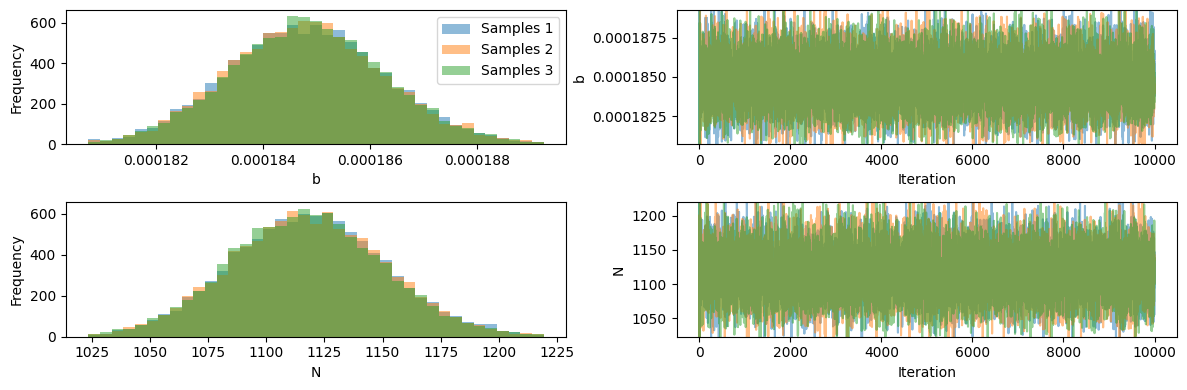

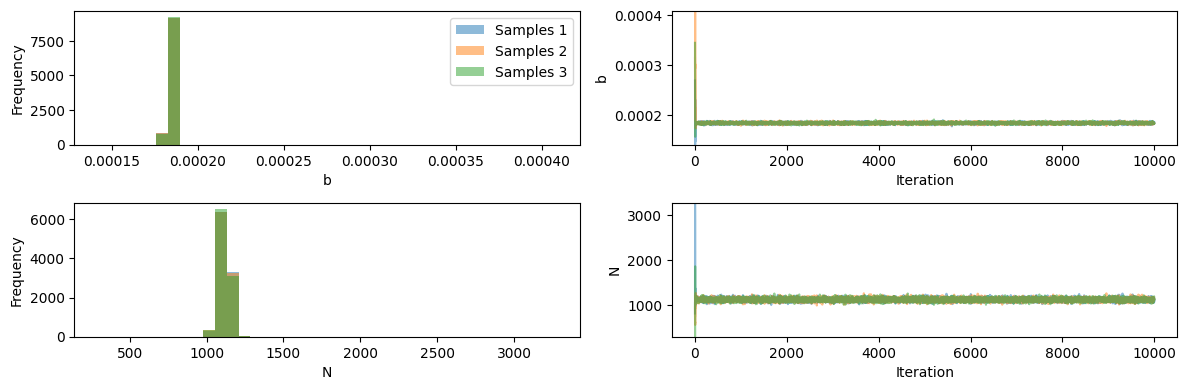

In [34]:
pints.plot.trace(chains[:,:,[0,1]], n_percentiles=99.5, parameter_names=["b","N"])
plt.savefig("pints_out_extremes_removed.png", dpi=300)
plt.show()
pints.plot.trace(chains[:,:,[0,1]], parameter_names=["b","N"])
plt.savefig("pints_out.png", dpi=300)
plt.show()

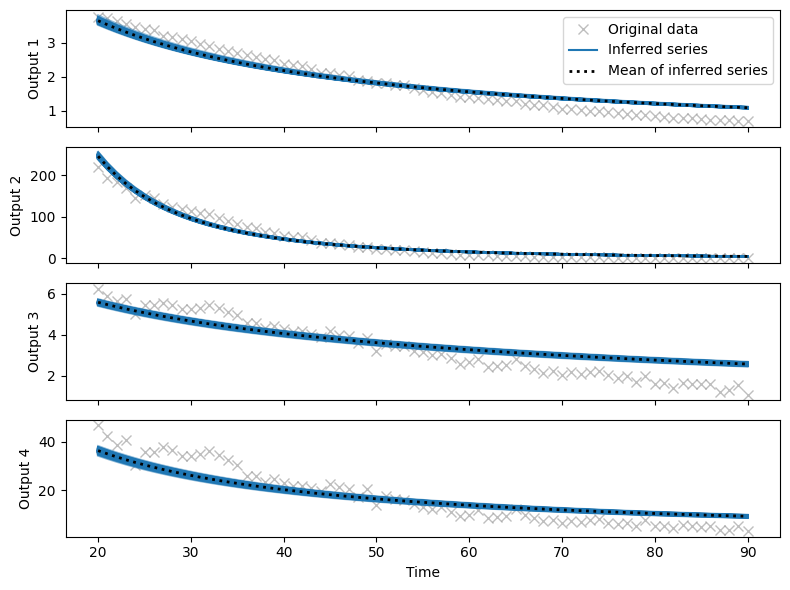

In [35]:
fig, axes = pints.plot.series(AllChains, problem)

# # Customise the plot, and add the original, noise-free data
# fig.set_size_inches(12,4.5)
# plt.plot(times, org_values, c='orange', label='Noise-free data')
# plt.legend()
# plt.show()

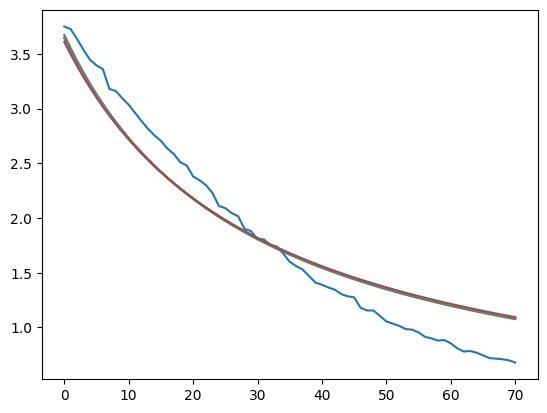

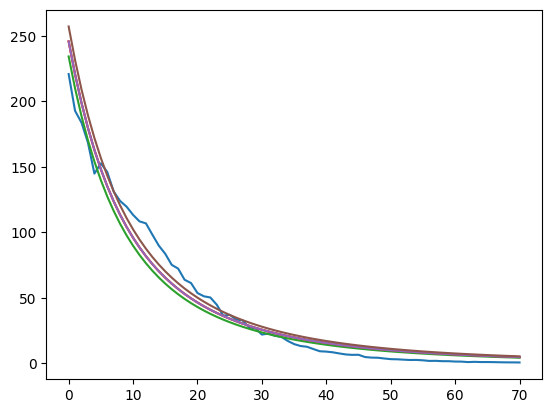

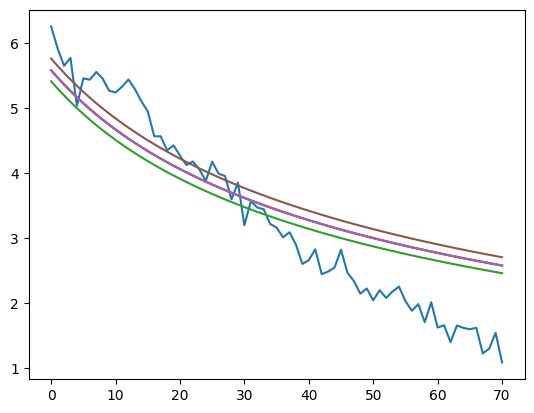

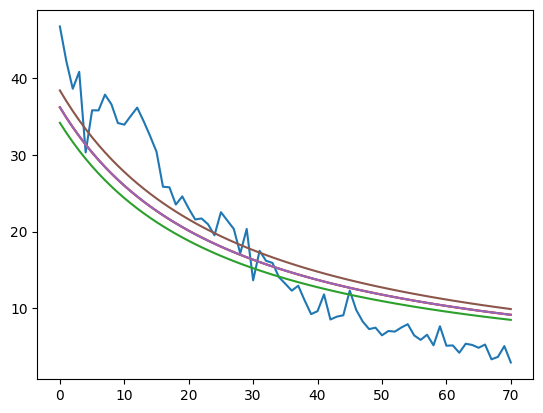

In [44]:

data_mean = out_array[:,0]
data_variance = out_array[:,1]
data_skewness = out_array[:,2]
data_kurtosis = out_array[:,3]

# for i in range(1000):
means = results.mean()[[0,1]]
st_devs = results.std()[[0,1]]

CI_0 = means

CI_1 = means + 2*st_devs

CI_2 = means
CI_2[0] += 2*st_devs[0]
CI_2[1] -= 2*st_devs[1] 

CI_3 = means
CI_3[0] -= 2*st_devs[0]
CI_3[1] += 2*st_devs[1] 

CI_4 = means - 2*st_devs

values_0 = model.simulate(CI_0, times)
values_1 = model.simulate(CI_1, times)
values_2 = model.simulate(CI_2, times)
values_3 = model.simulate(CI_3, times)
values_4 = model.simulate(CI_4, times)
# print(np.shape(values))

plt.plot(data_mean)
plt.plot(values_0[:,0])
plt.plot(values_1[:,0])
plt.plot(values_2[:,0])
plt.plot(values_3[:,0])
plt.plot(values_4[:,0])
plt.show()



plt.plot(data_variance)
plt.plot(values_0[:,1])
plt.plot(values_1[:,1])
plt.plot(values_2[:,1])
plt.plot(values_3[:,1])
plt.plot(values_4[:,1])
plt.show()


plt.plot(data_skewness)
plt.plot(values_0[:,2])
plt.plot(values_1[:,2])
plt.plot(values_2[:,2])
plt.plot(values_3[:,2])
plt.plot(values_4[:,2])
plt.show()

plt.plot(data_kurtosis)
plt.plot(values_0[:,3])
plt.plot(values_1[:,3])
plt.plot(values_2[:,3])
plt.plot(values_3[:,3])
plt.plot(values_4[:,3])
plt.show()

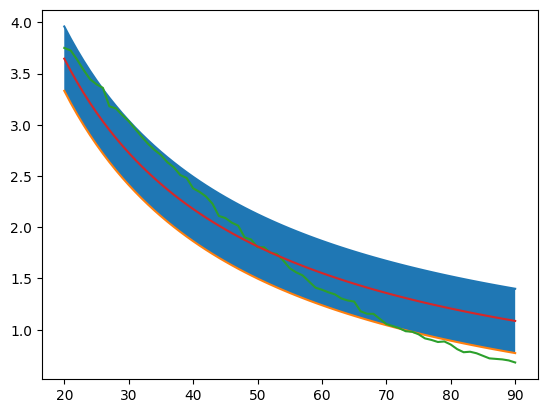

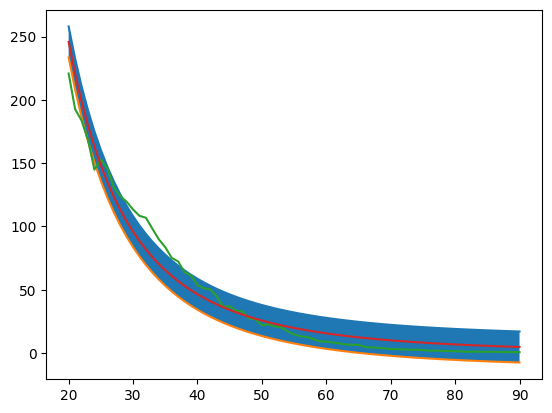

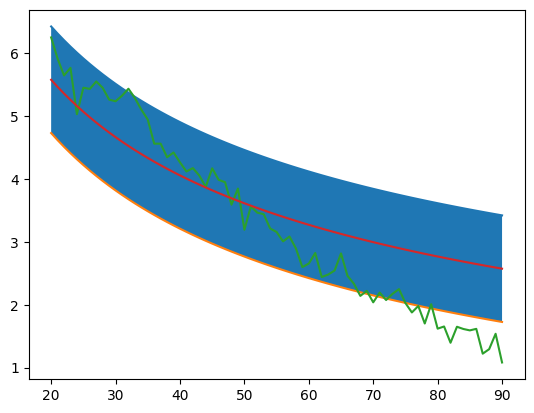

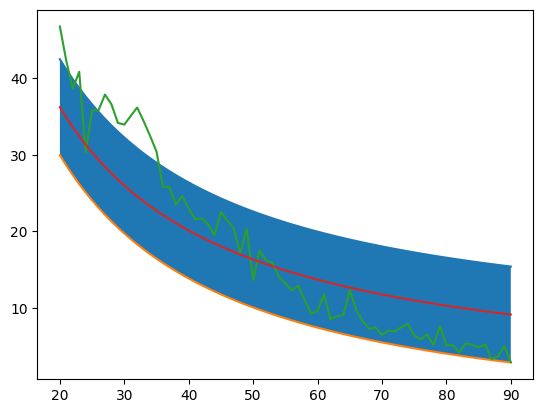

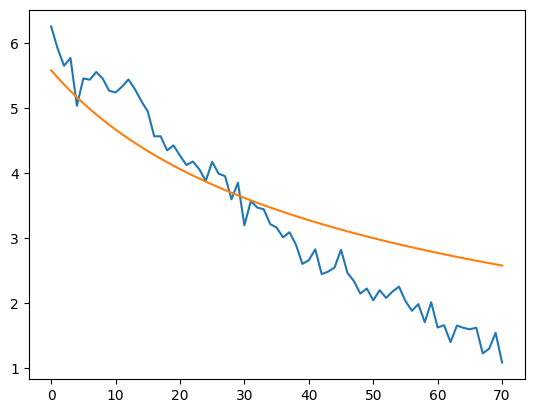

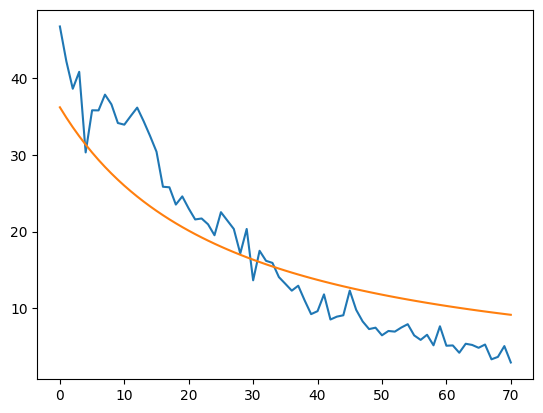

In [53]:

data_mean = out_array[:,0]
data_variance = out_array[:,1]
data_skewness = out_array[:,2]
data_kurtosis = out_array[:,3]

# for i in range(1000):
means = results.mean()[[0,1]]
st_devs = results.std()[[0,1]]

mean_CI = results.mean()[[2,3,4,5]]
st_devs_CI = results.std()[[2,3,4,5]]

CI_0 = means


values_0 = model.simulate(CI_0, times)
x=np.linspace(20,90,71)

y1=values_0[:,0]+mean_CI[0]+2*st_devs_CI[0]
y2=values_0[:,0]-mean_CI[0]-2*st_devs_CI[0]
plt.plot(x,y1)
plt.plot(x,y2)
plt.fill_between(x,y1,y2)
plt.plot(x,data_mean)
plt.plot(x,values_0[:,0])
plt.show()

y1=values_0[:,1]+mean_CI[1]+2*st_devs_CI[1]
y2=values_0[:,1]-mean_CI[1]-2*st_devs_CI[1]
plt.plot(x,y1)
plt.plot(x,y2)
plt.fill_between(x,y1,y2)
plt.plot(x,data_variance)
plt.plot(x,values_0[:,1])
plt.show()

y1=values_0[:,2]+mean_CI[2]+2*st_devs_CI[2]
y2=values_0[:,2]-mean_CI[2]-2*st_devs_CI[2]
plt.plot(x,y1)
plt.plot(x,y2)
plt.fill_between(x,y1,y2)
plt.plot(x,data_skewness)
plt.plot(x,values_0[:,2])
plt.show()


y1=values_0[:,3]+mean_CI[3]+2*st_devs_CI[3]
y2=values_0[:,3]-mean_CI[3]-2*st_devs_CI[3]
plt.plot(x,y1)
plt.plot(x,y2)
plt.fill_between(x,y1,y2)
plt.plot(x,data_kurtosis)
plt.plot(x,values_0[:,3])
plt.show()
